# Simple Time Series Example

This tutorial shows how a simple time series simulation is performed with the timeseries and control module in pandapower. A time series calculation requires the minimum following inputs:
* pandapower net
* the time series (in a pandas Dataframe for example)

First we need some imports. Specific for this example are:
* ConstControl -> "constant" controllers, which change the P and Q values of sgens and loads
* DFData -> The Dataframe Datasource. This Dataframe holds the time series to be calculated
* OutputWriter -> The output writer, which is required to write the outputs to the hard disk
* run_timeseries -> the "main" time series function, which basically calls the controller functions (to update the P, Q of the ConstControllers) and runpp.

In [1]:
import os
import numpy as np
import pandas as pd
import tempfile

import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

First we look at the time series example function. It follows these steps:
1. create a simple test net
2. create the datasource (which contains the time series P values)
3. create the controllers to update the P values of the load and the sgen
4. define the output writer and desired variables to be saved
5. call the main time series function to calculate the desired results

In [2]:
def timeseries_example(output_dir):
    # 1. create test net
    net = simple_test_net()

    # 2. create (random) data source
    n_timesteps = 24
    profiles, ds = create_data_source(n_timesteps)
    # 3. create controllers (to control P values of the load and the sgen)
    create_controllers(net, ds)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps)

We start by creating a simple example pandapower net consisting of five buses, a transformer, three lines, a load and a sgen. 

In [3]:
def simple_test_net():
    """
    simple net that looks like:

    ext_grid b0---b1 trafo(110/20) b2----b3 load
                                    |
                                    |
                                    b4 sgen
    """
    net = pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles=True)

    b0 = pp.create_bus(net, 110)
    b1 = pp.create_bus(net, 110)
    b2 = pp.create_bus(net, 20)
    b3 = pp.create_bus(net, 20)
    b4 = pp.create_bus(net, 20)

    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0")
    pp.create_transformer(net, b1, b2, "25 MVA 110/20 kV", name='tr1')
    pp.create_line(net, b2, b3, 10, "184-AL1/30-ST1A 20.0")
    pp.create_line(net, b2, b4, 10, "184-AL1/30-ST1A 20.0")

    pp.create_load(net, b2, p_mw=20., q_mvar=10., name='load1')
    pp.create_sgen(net, b4, p_mw=20., q_mvar=0.15, name='sgen1')

    return net

The data source is a simple pandas DataFrame. It contains random values for the load and the sgen P values ("profiles"). Of course your time series values should be loaded from a file later on.
Note that the profiles are identified by their column name ("load1_p", "sgen1_p"). You can choose here whatever you prefer.
The DFData(profiles) converts the Dataframe to the required format for the controllers. Note that the controller

In [4]:
def create_data_source(n_timesteps=24):
    profiles = pd.DataFrame()
    profiles['load1_p'] = np.random.random(n_timesteps) * 20.
    profiles['sgen1_p'] = np.random.random(n_timesteps) * 20.

    ds = DFData(profiles)

    return profiles, ds

create the controllers by telling the function which element_index belongs to which profile. In this case we map:
* first load in dataframe (element_index=[0]) to the profile_name "load1_p"
* first sgen in dataframe (element_index=[0]) to the profile_name "sgen1_p"

In [5]:
def create_controllers(net, ds):
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load1_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen1_p"])

create the output writer. Instead of saving the whole net (which takes a lot of time), we extract only pre defined outputs.
In this case we:
* save the results to "../timeseries/tests/outputs" 
* write the results to ".xls" Excel files. (Possible are: .json, .p, .csv)
* log the variables "p_mw" from "res_load", "vm_pu" from "res_bus" and two res_line values.

In [6]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xls", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

Now lets execute the code.

In [7]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: C:\Users\klsln\AppData\Local\Temp\time_series_example


  8%|▊         | 2/24 [00:02<00:32,  1.49s/it]c:\Users\klsln\anaconda3\lib\site-packages\pandapower\timeseries\output_writer.py:211: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  data.to_excel(file_path)
100%|██████████| 24/24 [00:03<00:00,  7.60it/s]


If everything works you should have the desired results the output_folder, which is the temporary folder of your operating system (see print statement above).

## Plot the result
Let's read the result from the disk and plot it

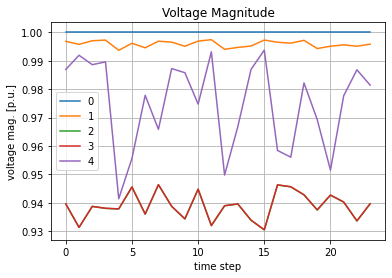

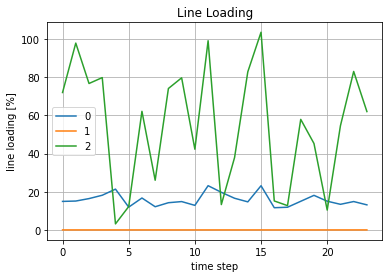

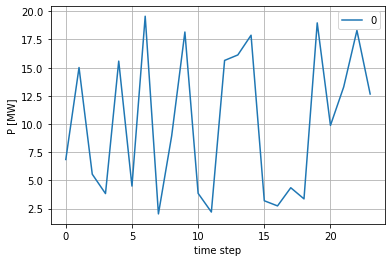

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xls")
vm_pu_tot = pd.read_excel(vm_pu_file)
vm_pu = vm_pu_tot[[0,1,2,3,4]]
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xls")
line_loading_tot = pd.read_excel(ll_file)
line_loading = line_loading_tot[[0,1,2]]
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xls")
load_tot = pd.read_excel(load_file)
load = load_tot[[0]]
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()